# Deep Learning Project 3 

Due Wednesday 11/4

## Convolutional Neural Networks and Image Classification

In this project, you will apply convolutional neural networks and ideas learned in Chapters 4 and 5 of our textbook to classify images in a dataset of your choice. 

### The Approach
Section 4.5 of the textbook outlines a clear workflow for solving a machine-learning problem. As a reminder, the steps included the following:
1. Defining the problem and assembling a dataset
2. Choosing a measure of success
3. Deciding on an evaluation protocol
4. Preparing the data
5. Developing a model that does better than a baseline
6. Scaling up: developing a model that overfits
7. Regularizing the model and tuning hyper parameters

For this project, you are required to follow the above workflow, documenting your work along the way in your report. For example, for the Humpback whale dataset, I would spend some time looking at the dataset to determine the number of classes, the number of samples per class, the number of pixels per image, etc. One key thing would be to decide the size of the images for my network given my computing power (i.e. I know that about 30 epochs on 150x150 dog-vs-cat images take several hours to process, where as it takes less time for MNIST 28x28 images.

### Requirements
Here are requirements for your work:
* You must design and attempt to train a convolutional network from scratch, following the workflow of section 4.5. 
* You must implement transfer learning (section 5.3) either through feature extraction or fine tuning. Choose one of the models prepackaged with Keras (Xception, VGG16, etc). 
* You must use of the three visualization techniques of section 5.4 to attempt to interpret your results.

### Timeline/What to turn in for Project 3

Suggested timeline:
* Wednesday 10/28: Chose a dataset and have a model that beats a baseline.
* Friday 10/30: Have successfully attempted transfer learning. 
* Monday 11/2: Have completed work to solve overfitting.
* Wednesday 11/4: Have completed visualization and interpretation.

**Your report for Project 3 (a Jupyter notebook with your code, comments in markup cells, and output cells) is due Wednesday 11/4 by midnight.**  

### Learning outcomes
After completing project 3, you will be able to:
* Implement convolutional neural networks for image classification problems
* Organize datasets and apply a workflow to solve a machine learning problem
* Make decisions regarding input data, model architecture, etc. that affect the solution of classification problems

In [ ]:
import keras
keras.__version__

'2.4.3'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import to_categorical

# 1. Defining the problem and assembling a dataset
The colorectal histology dataset from the TensorFlow catalog includes images of colorectal scans. These scans are from patients.

In [ ]:
#Get images from TensorFlow catalog and save as image, label
image, label = tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split='train', 
    batch_size=-1, 
    as_supervised=True,
))

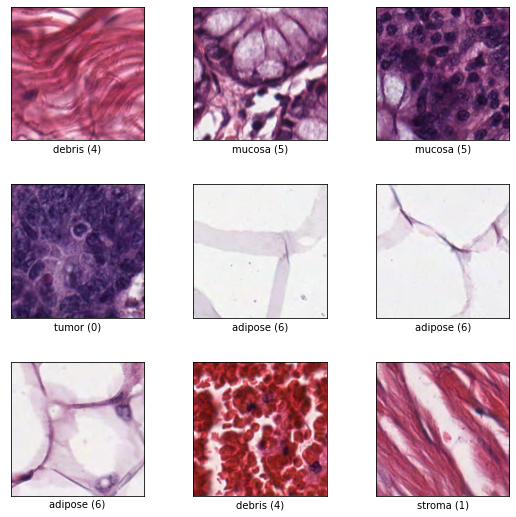

In [ ]:
ds, ds_info = tfds.load('colorectal_histology', split='train', with_info=True)
fig = tfds.show_examples(ds, ds_info)

Above are examples of what some of the samples look like along with their associated classes.

In [ ]:
#Find number of examples
print(image.shape)
print(label.shape)

(5000, 150, 150, 3)
(5000,)


There are 5000 images and 5000 labels. Each image is size 150x150.

In [ ]:
#Check class distribution
np.unique(label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([625, 625, 625, 625, 625, 625, 625, 625]))

As you can see from the labels above, there are 8 classes with each class having exactly 625 samples. A tumor is class 0. While that seems like the most important classifaction to make, each time of tissue can provide information to the patient, thus, this problem is a multi-class classification problem with 8 output classes. 

# 2. Choosing a measure of success
We are classifying a scan as 1 of 8 classes, with class 0 being a tumor. Accuracy seems like a goog universal metric of comparison that we can use to judge it versus other models. Additionally, we want to choose recall because it ensures that as many images/patients with tumors are being identified as possible.

# 3. Deciding on an evaluation protocol
For this example, we have plenty of image data. Thus, we will maintain a hold out validation set. If more is needed, we can procede with data augmentation to produce more data.

# 4. Preparing your data

In [ ]:
#Shuffle and create train/test/val split
import sklearn 
from sklearn.model_selection import train_test_split

#Create initial train test split
X_train, X_test, Y_train, Y_test = train_test_split(image, label, test_size=0.2, random_state=123)

#Split test into test/val
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=123)

In [ ]:
#Sanity check
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)

(4000, 150, 150, 3)
(500, 150, 150, 3)
(500, 150, 150, 3)
(4000,)
(500,)
(500,)


In [ ]:
#Normalize data & change type
X_train.astype(np.float64)
X_test.astype(np.float64)
X_val.astype(np.float64)
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

# 5. Developing a model that does better than a baseline
A naive model that assigned class type 1 to every image would be correct roughly 1/8 times, giving a baseline classification accuracy of roughly 12.5%.

In [ ]:
#Check class distribution
np.unique(label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([625, 625, 625, 625, 625, 625, 625, 625]))

And we can see that it would be 625/5000, exactly 12.5%! So to beat our baseline, we need to establish a model that can correctly classify images over 12.5% of the time.

In [ ]:
#Encode labels
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_val = to_categorical(Y_val)

In [ ]:
#Baseline model with small capacity

from keras import layers
from keras import models

baseline_model = models.Sequential()
baseline_model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
baseline_model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(32, activation='relu'))
baseline_model.add(layers.Dense(8, activation='softmax'))

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                5607456   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 5,608,616
Trainable params: 5,608,616
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compile the baseline model

from keras import optimizers
baseline_model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy', 'Recall'])

In [ ]:
#Fit baseline model
val = (X_val, Y_val);

history = baseline_model.fit(
X_train, Y_train, epochs=30,

validation_data=val)

Epoch 1/30
125/125 [==============================] - 2s 13ms/step - loss: 2.1057 - categorical_accuracy: 0.1920 - recall: 0.0050 - val_loss: 1.9958 - val_categorical_accuracy: 0.1820 - val_recall: 0.0020
Epoch 2/30
125/125 [==============================] - 1s 10ms/step - loss: 1.9704 - categorical_accuracy: 0.2390 - recall: 0.0122 - val_loss: 1.9622 - val_categorical_accuracy: 0.2160 - val_recall: 0.0220
Epoch 3/30
125/125 [==============================] - 1s 10ms/step - loss: 1.9458 - categorical_accuracy: 0.2447 - recall: 0.0330 - val_loss: 1.9459 - val_categorical_accuracy: 0.2120 - val_recall: 0.0460
Epoch 4/30
125/125 [==============================] - 1s 10ms/step - loss: 1.9221 - categorical_accuracy: 0.2460 - recall: 0.0507 - val_loss: 1.9302 - val_categorical_accuracy: 0.2160 - val_recall: 0.0320
Epoch 5/30
125/125 [==============================] - 1s 10ms/step - loss: 1.8713 - categorical_accuracy: 0.2840 - recall: 0.0688 - val_loss: 1.8169 - val_categorical_accuracy: 0.3

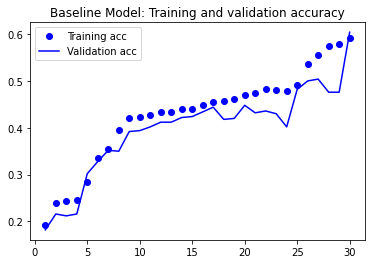

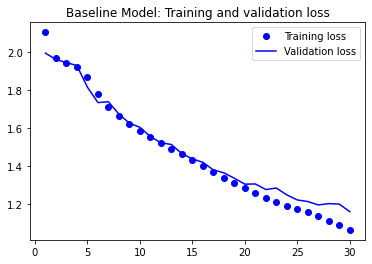

In [ ]:
#Plot performance of baseline model
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Baseline Model: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Baseline Model: Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#Save baseline model
baseline_model.save('baseline_model.h5')

Our baseline model performed well above a classifier that would assign one label and be correct 1/8 of the time. However, it is clear that the model was still training and more capacity would help it. 

# 6. Scaling up: developing a model that overfits

Let's try creating a higher capacity model to see if we can overfit, then decrease capacity from there to find the sweet spot.

In [ ]:
#Overfitting model with high capacity
overfitting_model = models.Sequential()
overfitting_model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
overfitting_model.add(layers.MaxPooling2D((2, 2)))
overfitting_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
overfitting_model.add(layers.MaxPooling2D((2, 2)))
overfitting_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
overfitting_model.add(layers.MaxPooling2D((2, 2)))
overfitting_model.add(layers.Flatten())
overfitting_model.add(layers.Dense(32, activation='relu'))
overfitting_model.add(layers.Dense(8, activation='softmax'))

In [ ]:
overfitting_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36992)            

In [ ]:
#Compile the overfitting model
from keras import optimizers
overfitting_model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy', 'Recall'])

In [ ]:
#Fit overfitting model
val = (X_val, Y_val);

history2 = overfitting_model.fit(
X_train, Y_train, epochs=30,
validation_data=val)

Epoch 1/30
125/125 [==============================] - 2s 17ms/step - loss: 1.6530 - categorical_accuracy: 0.3368 - recall: 0.0970 - val_loss: 1.4126 - val_categorical_accuracy: 0.4740 - val_recall: 0.2380
Epoch 2/30
125/125 [==============================] - 2s 15ms/step - loss: 1.3920 - categorical_accuracy: 0.4485 - recall: 0.2048 - val_loss: 1.3217 - val_categorical_accuracy: 0.5820 - val_recall: 0.2800
Epoch 3/30
125/125 [==============================] - 2s 15ms/step - loss: 1.2536 - categorical_accuracy: 0.5282 - recall: 0.2498 - val_loss: 1.1066 - val_categorical_accuracy: 0.6160 - val_recall: 0.3800
Epoch 4/30
125/125 [==============================] - 2s 15ms/step - loss: 1.1453 - categorical_accuracy: 0.5878 - recall: 0.3358 - val_loss: 1.0151 - val_categorical_accuracy: 0.6340 - val_recall: 0.3860
Epoch 5/30
125/125 [==============================] - 2s 15ms/step - loss: 1.0497 - categorical_accuracy: 0.6263 - recall: 0.3980 - val_loss: 0.9713 - val_categorical_accuracy: 0.6

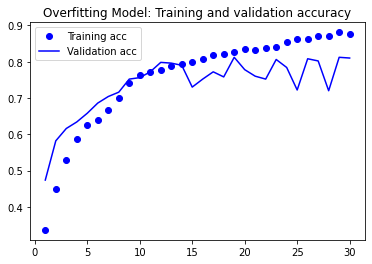

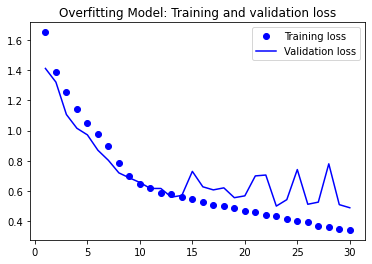

In [ ]:
#Plot performance of overfitting model
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Overfitting Model: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Overfitting Model: Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#Save overfitting model
overfitting_model.save('overfitting_model.h5')

We didn't quite overfit. Let's try keeping the number of Conv2D layers the same and adding more dense layers to see if this can add enough capacity to create overfitting.

In [ ]:
#Overfitting model 2 with more capacity through dense layers
from keras import layers
from keras import models

overfitting_model2 = models.Sequential()
overfitting_model2.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(150, 150, 3)))
overfitting_model2.add(layers.MaxPooling2D((2, 2)))
overfitting_model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
overfitting_model2.add(layers.MaxPooling2D((2, 2)))
overfitting_model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
overfitting_model2.add(layers.MaxPooling2D((2, 2)))
overfitting_model2.add(layers.Flatten())
overfitting_model2.add(layers.Dense(128, activation='relu'))
overfitting_model2.add(layers.Dense(64, activation='relu'))
overfitting_model2.add(layers.Dense(32, activation='relu'))
overfitting_model2.add(layers.Dense(8, activation='softmax'))


In [ ]:
overfitting_model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)            

In [ ]:
#Compile the overfitting2 model
from keras import optimizers
overfitting_model2.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy', 'Recall'])

In [ ]:
#Fit the overfitting2 model
val = (X_val, Y_val);

history3 = overfitting_model2.fit(
X_train, Y_train, epochs=30,
validation_data=val)

Epoch 1/30
125/125 [==============================] - 2s 18ms/step - loss: 1.5763 - categorical_accuracy: 0.3372 - recall: 0.0688 - val_loss: 1.2208 - val_categorical_accuracy: 0.5180 - val_recall: 0.1660
Epoch 2/30
125/125 [==============================] - 2s 16ms/step - loss: 1.1658 - categorical_accuracy: 0.5257 - recall: 0.2822 - val_loss: 1.0597 - val_categorical_accuracy: 0.5220 - val_recall: 0.3880
Epoch 3/30
125/125 [==============================] - 2s 16ms/step - loss: 1.0149 - categorical_accuracy: 0.5835 - recall: 0.4103 - val_loss: 0.9133 - val_categorical_accuracy: 0.6400 - val_recall: 0.5060
Epoch 4/30
125/125 [==============================] - 2s 16ms/step - loss: 0.9303 - categorical_accuracy: 0.6273 - recall: 0.5008 - val_loss: 0.8861 - val_categorical_accuracy: 0.6440 - val_recall: 0.5120
Epoch 5/30
125/125 [==============================] - 2s 16ms/step - loss: 0.8615 - categorical_accuracy: 0.6587 - recall: 0.5562 - val_loss: 0.9206 - val_categorical_accuracy: 0.6

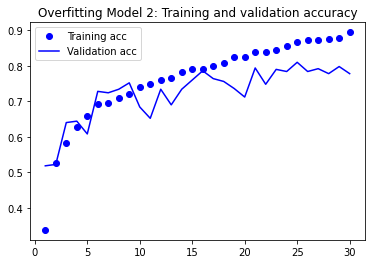

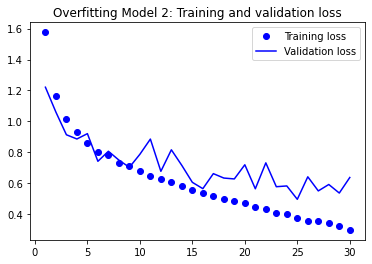

In [ ]:
#Plot performance of overfitting2 model
acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Overfitting Model 2: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Overfitting Model 2: Training and validation loss')
plt.legend()
plt.show()

We have overfit roughly 15-20 epochs in.

In [ ]:
#Save overfitting model2
overfitting_model2.save('overfitting_model2.h5')

Our model overfit! Let's also try transfer learning to see how this approach fares.

 **Try Transfer Learning**

Let's try using the VGG16 model. We'll freeze the conv layers to preserve them but add our own dense layers so the network can learn patterns from our data while using the pretrained conv layers of VGG16.

In [ ]:
#Try transfer learning
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, input_shape=(150, 150, 3))
vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
# Freeze all the conv layers
for layer in vgg16.layers[:]:
    layer.trainable = False

In [ ]:
#Create a dense model
from keras import layers
from keras import models
combined = models.Sequential()

#Add existing vgg16
combined.add(vgg16)

#Add new
combined.add(layers.Flatten())
combined.add(layers.Dense(128, activation='relu'))
combined.add(layers.Dense(64, activation='relu'))
combined.add(layers.Dense(32, activation='relu'))
combined.add(layers.Dense(8, activation='softmax'))

combined.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
Total params: 15,773,992
Trainable params: 1,059,304
Non-trainable params: 14,714,688
____________________________________

In [ ]:
#Compile the combined model
from keras import optimizers
combined.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy', 'Recall'])

In [ ]:
#Fit the combined model
val = (X_val, Y_val);

history4 = combined.fit(
X_train, Y_train, epochs=30,
validation_data=val)

Epoch 1/30
125/125 [==============================] - 4s 34ms/step - loss: 1.1853 - categorical_accuracy: 0.6615 - recall: 0.2845 - val_loss: 0.7186 - val_categorical_accuracy: 0.8180 - val_recall: 0.6200
Epoch 2/30
125/125 [==============================] - 4s 30ms/step - loss: 0.6161 - categorical_accuracy: 0.8250 - recall: 0.6790 - val_loss: 0.4942 - val_categorical_accuracy: 0.8520 - val_recall: 0.7720
Epoch 3/30
125/125 [==============================] - 4s 30ms/step - loss: 0.4416 - categorical_accuracy: 0.8677 - recall: 0.8030 - val_loss: 0.4745 - val_categorical_accuracy: 0.8440 - val_recall: 0.7960
Epoch 4/30
125/125 [==============================] - 4s 30ms/step - loss: 0.3588 - categorical_accuracy: 0.8932 - recall: 0.8505 - val_loss: 0.4181 - val_categorical_accuracy: 0.8540 - val_recall: 0.8160
Epoch 5/30
125/125 [==============================] - 4s 30ms/step - loss: 0.3060 - categorical_accuracy: 0.9093 - recall: 0.8755 - val_loss: 0.3615 - val_categorical_accuracy: 0.8

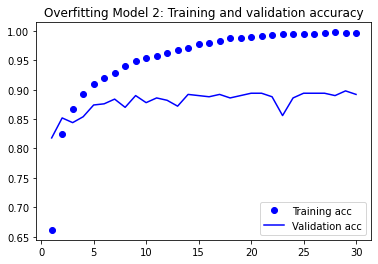

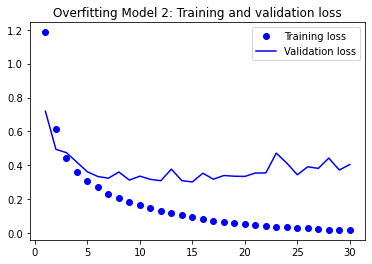

In [ ]:
#Plot performance
acc = history4.history['categorical_accuracy']
val_acc = history4.history['val_categorical_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Transfer Learning Model: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Transfer Learning Model: Training and validation loss')
plt.legend()
plt.show()

It appears we began to overfit around epoch 15 as training and validation accuracy leveled out.

In [ ]:
#Save transfer model
combined.save('combined.h5')

# 7. Regularizing the model and tuning hyper parameters

VGG16 provided our best performance yet, however it overfit quickly as the validation accuracy evened out around 90%. Let's try three techniques to mitigate the overfitting: 


1.   Dropout
2.   Reducing Capacity
3.   Data Augmentation

We will then take a combination of these three to produce a final model on top of VGG16.



In [ ]:
#Try adding dropout
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, input_shape=(150, 150, 3))
vgg16.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
# Freeze all the conv layers
for layer in vgg16.layers[:]:
    layer.trainable = False

In [ ]:
#Create a dropout model
from keras import layers
from keras import models
from keras.layers import Dropout
dropout = models.Sequential()

#Add existing vgg16
dropout.add(vgg16)

#Add new
dropout.add(layers.Flatten())
dropout.add(layers.Dense(128, activation='relu'))
dropout.add(Dropout(0.4))
dropout.add(layers.Dense(64, activation='relu'))
dropout.add(Dropout(0.4))
dropout.add(layers.Dense(32, activation='relu'))
dropout.add(layers.Dense(8, activation='softmax'))

dropout.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)               

In [ ]:
#Compile the dropout model
from keras import optimizers
dropout.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy', 'Recall'])

In [ ]:
#Fit the combined model
val = (X_val, Y_val);

history5 = dropout.fit(
X_train, Y_train, epochs=30,
validation_data=val)

Epoch 1/30
125/125 [==============================] - 6s 46ms/step - loss: 1.7176 - categorical_accuracy: 0.3392 - recall: 0.0988 - val_loss: 1.1476 - val_categorical_accuracy: 0.7340 - val_recall: 0.2640
Epoch 2/30
125/125 [==============================] - 5s 40ms/step - loss: 1.3110 - categorical_accuracy: 0.5215 - recall: 0.2600 - val_loss: 0.8154 - val_categorical_accuracy: 0.8000 - val_recall: 0.4400
Epoch 3/30
125/125 [==============================] - 5s 39ms/step - loss: 1.1015 - categorical_accuracy: 0.6162 - recall: 0.3760 - val_loss: 0.6800 - val_categorical_accuracy: 0.8040 - val_recall: 0.5920
Epoch 4/30
125/125 [==============================] - 5s 39ms/step - loss: 0.9468 - categorical_accuracy: 0.6697 - recall: 0.4793 - val_loss: 0.5896 - val_categorical_accuracy: 0.8320 - val_recall: 0.6660
Epoch 5/30
125/125 [==============================] - 5s 39ms/step - loss: 0.8422 - categorical_accuracy: 0.7170 - recall: 0.5642 - val_loss: 0.5243 - val_categorical_accuracy: 0.8

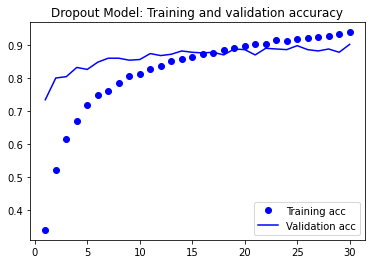

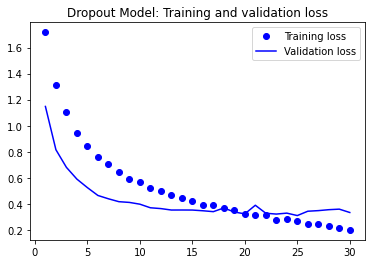

In [ ]:
#Plot performance
acc = history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Dropout Model: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Dropout Model: Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#Save dropout model
dropout.save('dropout.h5')

It looks like dropout helped overfitting but didn't completely solve it. We overfit beginning at roughly epoch ~20. Dropouts ranging from 0.25-0.5 were used, but 0.4 seemed to be the "sweet spot". Let's try altering the model's capacity in the dense layers next.

In [ ]:
#Try reducing capacity
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, input_shape=(150, 150, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# Freeze all the conv layers
for layer in vgg16.layers[:]:
    layer.trainable = False

In [ ]:
#Create a reduced capacity model
from keras import layers
from keras import models
from keras.layers import Dropout
rc = models.Sequential()

#Add existing vgg16
rc.add(vgg16)

#Add new
rc.add(layers.Flatten())
rc.add(layers.Dense(32, activation='relu'))
rc.add(layers.Dense(8, activation='softmax'))

rc.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                262176    
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 264       
Total params: 14,977,128
Trainable params: 262,440
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#Compile the reduced capacity model
from keras import optimizers
rc.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy', 'Recall'])

In [ ]:
#Fit the reduced capacity model
val = (X_val, Y_val);

history6 = rc.fit(
X_train, Y_train, epochs=30,
validation_data=val)

Epoch 1/30
125/125 [==============================] - 5s 41ms/step - loss: 1.1817 - categorical_accuracy: 0.6605 - recall: 0.2718 - val_loss: 0.7378 - val_categorical_accuracy: 0.8160 - val_recall: 0.5520
Epoch 2/30
125/125 [==============================] - 5s 39ms/step - loss: 0.6471 - categorical_accuracy: 0.8085 - recall: 0.6538 - val_loss: 0.5436 - val_categorical_accuracy: 0.8380 - val_recall: 0.7480
Epoch 3/30
125/125 [==============================] - 5s 39ms/step - loss: 0.5034 - categorical_accuracy: 0.8528 - recall: 0.7638 - val_loss: 0.4557 - val_categorical_accuracy: 0.8580 - val_recall: 0.7820
Epoch 4/30
125/125 [==============================] - 5s 39ms/step - loss: 0.4322 - categorical_accuracy: 0.8668 - recall: 0.8085 - val_loss: 0.4300 - val_categorical_accuracy: 0.8600 - val_recall: 0.8060
Epoch 5/30
125/125 [==============================] - 5s 39ms/step - loss: 0.3823 - categorical_accuracy: 0.8815 - recall: 0.8290 - val_loss: 0.4234 - val_categorical_accuracy: 0.8

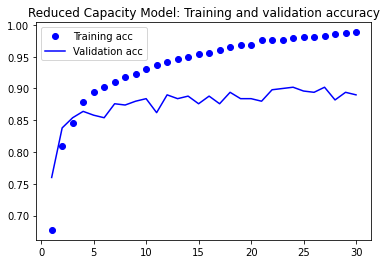

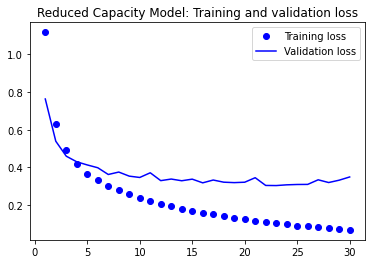

In [ ]:
#Plot performance
acc = history6.history['categorical_accuracy']
val_acc = history6.history['val_categorical_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Reduced Capacity Model: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Reduced Capacity Model: Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#Save transfer model
rc.save('rc.h5')

It looks like reducing capacity hurt validation accuracy a little, but let's try data augmentation to give the model more data to learn from.

In [ ]:
#Set up data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

In [ ]:
#Create generator
it = datagen.flow(X_train, Y_train)

In [ ]:
#Grab model
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, input_shape=(150, 150, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# Freeze all the conv layers
for layer in vgg16.layers[:]:
    layer.trainable = False

In [ ]:
#Create a model using data augmentation
from keras import layers
from keras import models
da = models.Sequential()

#Add existing vgg16
da.add(vgg16)

#Add new
da.add(layers.Flatten())
da.add(layers.Dense(128, activation='relu'))
da.add(layers.Dense(64, activation='relu'))
da.add(layers.Dense(32, activation='relu'))
da.add(layers.Dense(8, activation='softmax'))

da.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 264       
Total params: 15,773,992
Trainable params: 1,059,304
Non-trainable params: 14,714,688
__________________________________

In [ ]:
#Compile the model
from keras import optimizers
da.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy', 'Recall'])

In [ ]:
#Fit model on the augmented dataset
history7 = da.fit_generator(it, epochs=30, validation_data=(X_val, Y_val))

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/30
125/125 [==============================] - 20s 159ms/step - loss: 1.1880 - categorical_accuracy: 0.6030 - recall: 0.2848 - val_loss: 0.7016 - val_categorical_accuracy: 0.7880 - val_recall: 0.5820
Epoch 2/30
125/125 [==============================] - 20s 156ms/step - loss: 0.7187 - categorical_accuracy: 0.7625 - recall: 0.6045 - val_loss: 0.5138 - val_categorical_accuracy: 0.8280 - val_recall: 0.7380
Epoch 3/30
125/125 [==============================] - 20s 157ms/step - loss: 0.5938 - categorical_accuracy: 0.8010 - recall: 0.7070 - val_loss: 0.4424 - val_categorical_accuracy: 0.8340 - val_recall: 0.7780
Epoch 4/30
125/125 [==============================] - 20s 157ms/step - loss: 0.5293 - categorical_accuracy: 0.8152 - recall: 0.7483 - val_loss: 0.4026 - val_categorical_accuracy: 0.8560 - val_recall: 0.8080
Epoch 5/30
125/125 [==============================] - 20s 157ms/step - loss: 0.4972 - categorical_accuracy: 0.8298 - recall: 0.7797 - val_loss: 0.4185 - val_categorical_acc

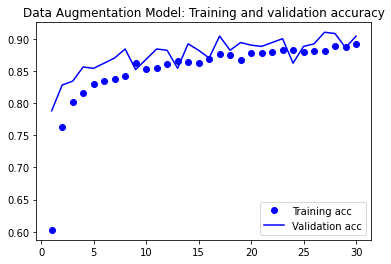

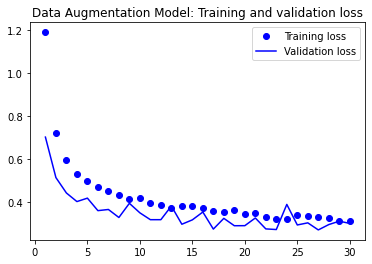

In [ ]:
#Plot performance
acc = history7.history['categorical_accuracy']
val_acc = history7.history['val_categorical_accuracy']
loss = history7.history['loss']
val_loss = history7.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Data Augmentation Model: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Data Augmentation Model: Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#Save transfer model
da.save('da.h5')

Let's try comining techniques to mitigate overfitting to produce a final model.

In [ ]:
#Try combining all techniques to produce a final model
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(include_top=False, input_shape=(150, 150, 3))

# Freeze all the conv layers
for layer in vgg16.layers[:]:
    layer.trainable = False

#Create a final model
from keras import layers
from keras import models
from keras.layers import Dropout
final = models.Sequential()

#Add existing vgg16
final.add(vgg16)

#Add new
final.add(layers.Flatten())
final.add(layers.Dense(64, activation='relu'))
final.add(Dropout(0.2))
final.add(layers.Dense(32, activation='relu'))
final.add(Dropout(0.2))
final.add(layers.Dense(8, activation='softmax'))

final.summary()

#Compile the final model
from keras import optimizers
final.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy', 'Recall'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                

In [ ]:
#Set up data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

it2 = datagen.flow(X_train, Y_train)

In [ ]:
#Fit final model on the augmented dataset
history8 = final.fit_generator(it2, epochs=30, validation_data=(X_val, Y_val))

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/30
125/125 [==============================] - ETA: 0s - batch: 62.0000 - size: 32.0000 - loss: 1.6017 - categorical_accuracy: 0.4370 - Recall: 0.1235WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


125/125 [==============================] - 19s 148ms/step - batch: 62.0000 - size: 32.0000 - loss: 1.6017 - categorical_accuracy: 0.4370 - Recall: 0.1235 - val_loss: 1.0429 - val_categorical_accuracy: 0.7380 - val_Recall: 0.3620
Epoch 2/30
125/125 [==============================] - 18s 148ms/step - batch: 62.0000 - size: 32.0000 - loss: 1.1918 - categorical_accuracy: 0.5865 - Recall: 0.3243 - val_loss: 0.7741 - val_categorical_accuracy: 0.8000 - val_Recall: 0.5000
Epoch 3/30
125/125 [==============================] - 19s 149ms/step - batch: 62.0000 - size: 32.0000 - loss: 1.0173 - categorical_accuracy: 0.6440 - Recall: 0.4338 - val_loss: 0.6416 - val_categorical_accuracy: 0.8180 - val_Recall: 0.6240
Epoch 4/30
125/125 [==============================] - 19s 149ms/step - batch: 62.0000 - size: 32.0000 - loss: 0.9339 - categorical_accuracy: 0.6808 - Recall: 0.4865 - val_loss: 0.5686 - val_categorical_accuracy: 0.8280 - val_Recall: 0.7020
Epoch 5/30
125/125 [==============================]

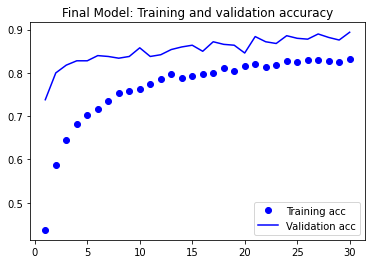

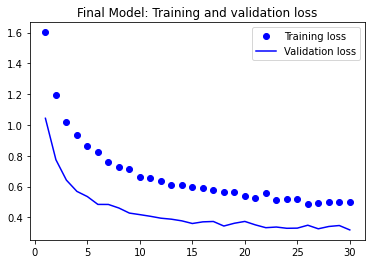

In [ ]:
#Plot performance
acc = history8.history['categorical_accuracy']
val_acc = history8.history['val_categorical_accuracy']
loss = history8.history['loss']
val_loss = history8.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Final Model: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Final Model: Training and validation loss')
plt.legend()
plt.show()

In [ ]:
final.evaluate(X_test, Y_test, verbose=1)

[0.314673187494278, 0.886, 0.854]

In [ ]:
#Save final model
final.save('final.h5')

In [ ]:
#Load final model if runtime disconnects
final = keras.models.load_model("final.h5")

Our final model actually had better validation accuracy than training accuracy. Test accuracy was 88.6% and recall was 85.4%. This model utilized dropout, data augmentation, and slightly reduced capacity on top of the VGG16 model.


 Now that we have our "final" model, let's try to visualize what each layer of the VGG16 is doing to an image to gather information from it to help with classification.



In [ ]:
#Get unprocessed tumor cell picture
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
x = image[4]
x = np.expand_dims(x, axis=0)
x = x / 255.

(1, 150, 150, 3)


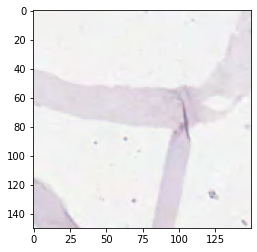

In [ ]:
#Show the test image
plt.imshow(x[0])
plt.show()

In [ ]:
#Instantiating model from an input tensor and a list of output tensors
from keras import models
model = final.get_layer('vgg16')
layer_outputs = [
                 layer.output 
                 for layer in model.layers[:8]
                 ][1:]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
#Returns a list of numpy arrays for each layer's activation
activations = activation_model.predict(x)

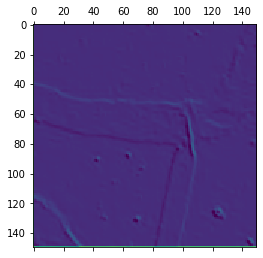

In [ ]:
#Visualize the fourth channel of first layer's activation
import matplotlib.pyplot as plt
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

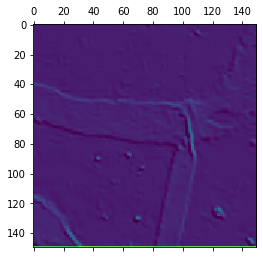

In [ ]:
#Visualize the seventh channel of first layer's activation
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


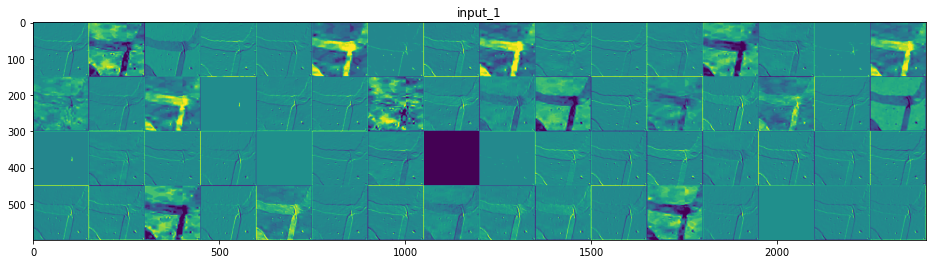

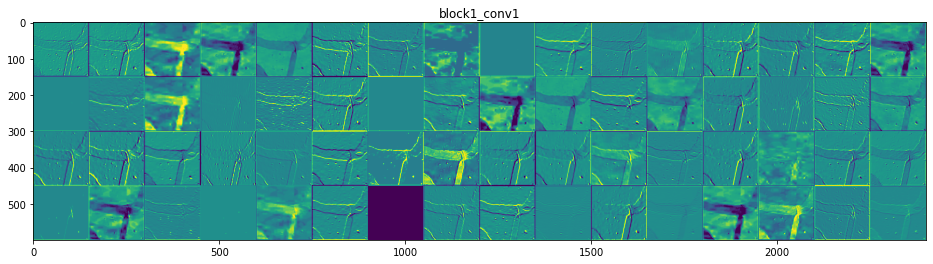

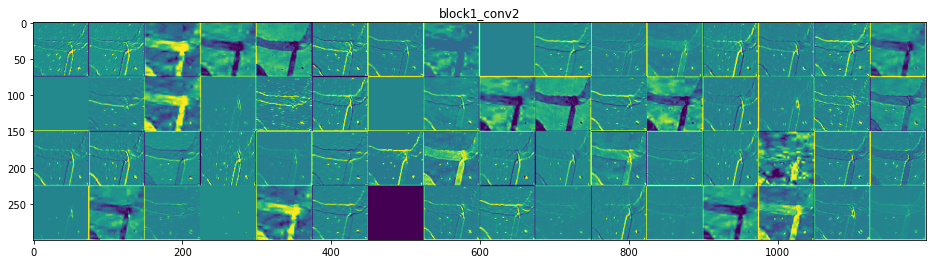

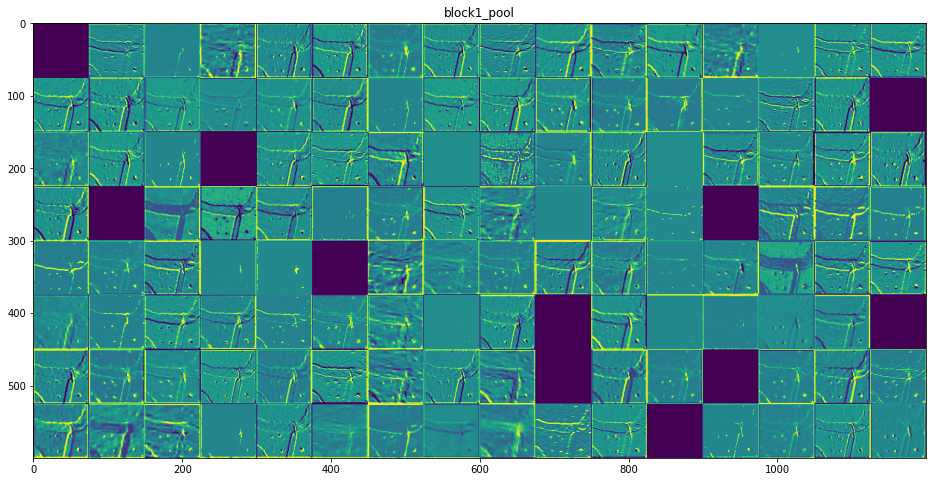

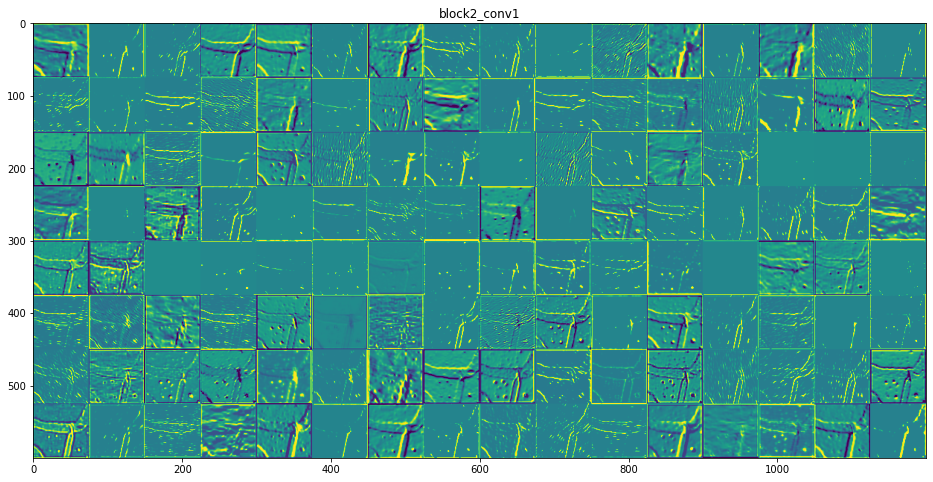

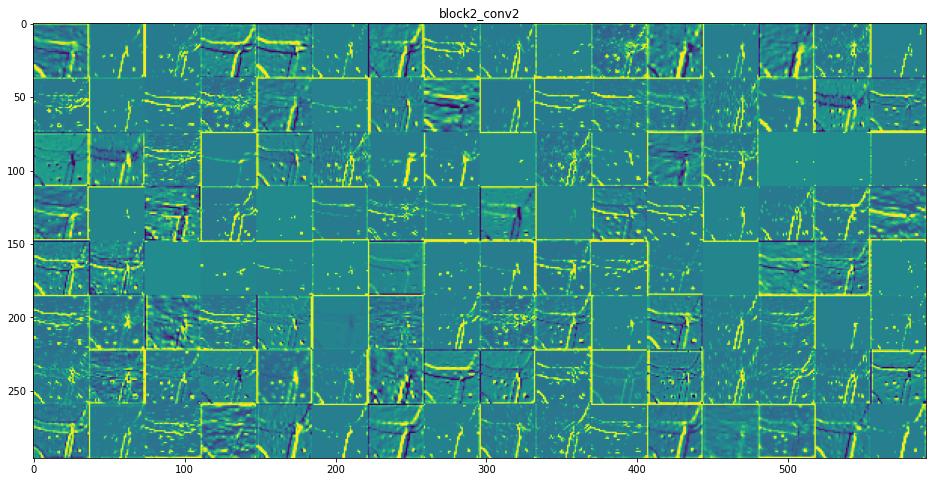

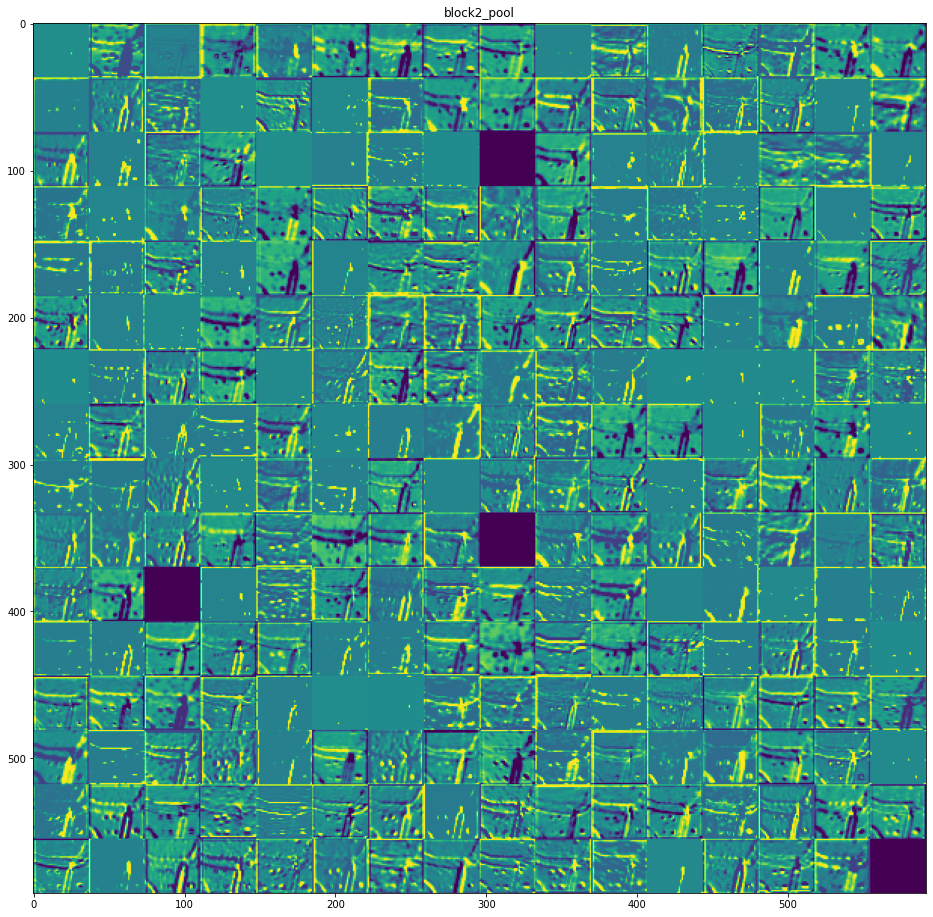

In [ ]:
#Visualizing every channel in every intermediate activation
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:, :,col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
  scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis') 

Here we can see every channel of all the layer activations in the test picture of a tumor. This allows us to see what changes the VGG16 network is making to the image as it goes through each layer to gather information for a network. The images lose resolution and clarity as they proceed. 


The block1_conv1 and block1_conv2 layers seems to be primarily to identify edges and shape as shape has a clarity to it. The block1_pool reduces the amount of information in the image through pooling.

The block2_conv1 and block2_conv2 layers have less detail as a result of the pooling, so the most prevalent patterns and information appear. It is harder to see what is going on in the image, thus facilitating higher level patterns being identified for the tumor class. Additionally, there are more blank filters lower down, suggesting that whatever exists in that filter isn't present in this sample. This could be to identify another class or another pattern shared between other images.

The book puts it best: this network is a "information distillation pipeline", removing useless information for classification.

We leverage this pre-trained VGG16 network to help identify key information in our images, then we added new dense layers to learn from what information VGG16 is providing. This type of transfer learning allows us to use VGG16's pretrained functional model via freezing those layers to help with our classification task.


**Citations:**
- Deep Learning With Python: Chapter 5